In [1]:
#Libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

# modeling and evaluating
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Exploring
import scipy.stats as stats
import math

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
# pd.options.display.float_format = '{:20,.2f}'.format

# import acquire
# import summarize
# import prepare

In [2]:
import os
import env

credentials loaded successfully


In [3]:
import acquire

End of file.


In [4]:
df = acquire.get_mallcustomer_data()
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [5]:
# create dummy var with gender, drop the first dummy var. 

df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
df.drop(columns=['gender'], inplace=True)
df.head()

,age,annual_income,spending_score,is_male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0


In [6]:
# Summarize: IS the data ready to explore?

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             200 non-null    int64
 1   annual_income   200 non-null    int64
 2   spending_score  200 non-null    int64
 3   is_male         200 non-null    uint8
dtypes: int64(3), uint8(1)
memory usage: 6.4 KB


In [7]:
df.describe()

,age,annual_income,spending_score,is_male
count,200.000000,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000,0.440000
std,13.969007,26.264721,25.823522,0.497633
min,18.000000,15.000000,1.000000,0.000000
25%,28.750000,41.500000,34.750000,0.000000
50%,36.000000,61.500000,50.000000,0.000000
75%,49.000000,78.000000,73.000000,1.000000
max,70.000000,137.000000,99.000000,1.000000


I need to split the data, and then scale it

In [8]:
# split off test, 20% of original df size

train_validate, test = train_test_split(df, test_size=.20, 
                                        random_state=42)

# split off validate, 30% of train_validate (24% of original)
train, validate = train_test_split(train_validate, test_size=.30, 
                                   random_state=42)

In [9]:
print("train obs: ", train.size)
print("validate obs: ", validate.size)
print("test obs: ", test.size)

train obs:  448
validate obs:  192
test obs:  160


## Explore

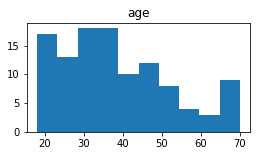

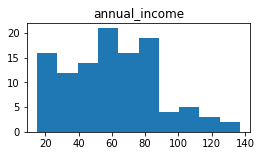

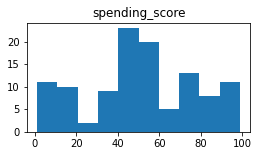

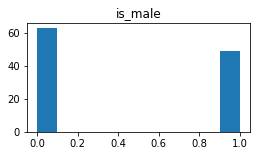

In [10]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

#### Takeaways:

- `spending_score` is normally distributed
- For binning, I might want to find a breakpoint for `annual_income` on the quartiles I saw in .describe()
- There are slightly more females in the sample data than males.

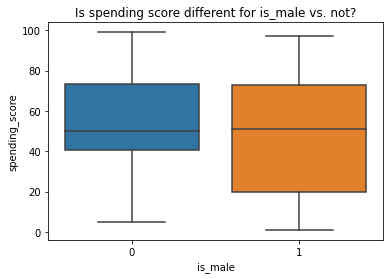

In [11]:
sns.boxplot(train.is_male, train.spending_score)
plt.title("Is spending score different for is_male vs. not?")
plt.show()

In [12]:
# Setting the alpha level:

alpha = .05

confidence_level = 1 - alpha
confidence_level, alpha

(0.95, 0.05)

Hypothesis:

- $ H_0 $: There is no variance in the spending between female and male shoppers
- $ H_a $: There is a statistically significant variation in spending between female and male shoppers

In [13]:
not_male_gp = train[train.is_male==0]
is_male_gp = train[train.is_male==1]

stats.levene(not_male_gp.spending_score, is_male_gp.spending_score)

LeveneResult(statistic=1.52123656007133, pvalue=0.22006154667448222)

Result:
- The p-value > alpha, thus we fail to reject the null hypothesis. The spending does not differ significantly across gender.

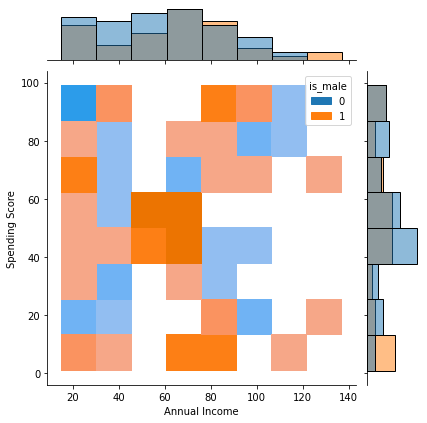

In [14]:
# Is there a relationship between annual income and spending score?

sns.jointplot(x = 'annual_income', y = "spending_score", data = train, kind = "hist", hue = 'is_male')
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

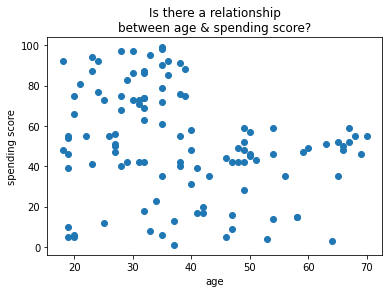

In [15]:
# plot age by spending score

plt.scatter(train.age, train.spending_score)
plt.xlabel("age")
plt.ylabel("spending score")
plt.title("Is there a relationship\nbetween age & spending score?")
plt.show()

<AxesSubplot:xlabel='age_bin', ylabel='spending_score'>

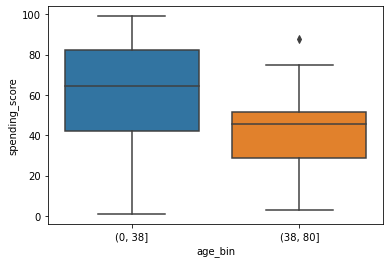

In [16]:
# create age bins
train['age_bin'] = pd.cut(train.age, [0, 38, 80])

# box plot of the two groups & spending score
sns.boxplot(train.age_bin, train.spending_score)

In [17]:
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
131,47,71,9,1,"(38, 80]"
63,67,47,52,0,"(38, 80]"
14,24,20,77,0,"(0, 38]"
174,36,87,92,1,"(0, 38]"
145,25,77,12,1,"(0, 38]"


In [18]:
# test the assumption of equal variance

stats.levene(train[train.age <= 38].spending_score, 
             train[train.age > 38].spending_score
            )

LeveneResult(statistic=10.329683073078543, pvalue=0.0017181840920581094)

In [19]:
stats.ttest_ind(train[train.age <=38].spending_score, train[train.age > 38].spending_score, equal_var = False)

Ttest_indResult(statistic=4.22014211372668, pvalue=5.047400730809076e-05)

In [20]:
# bin income into 3 bins

train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

Interaction of variables along with younger vs older
(cutoff=40)


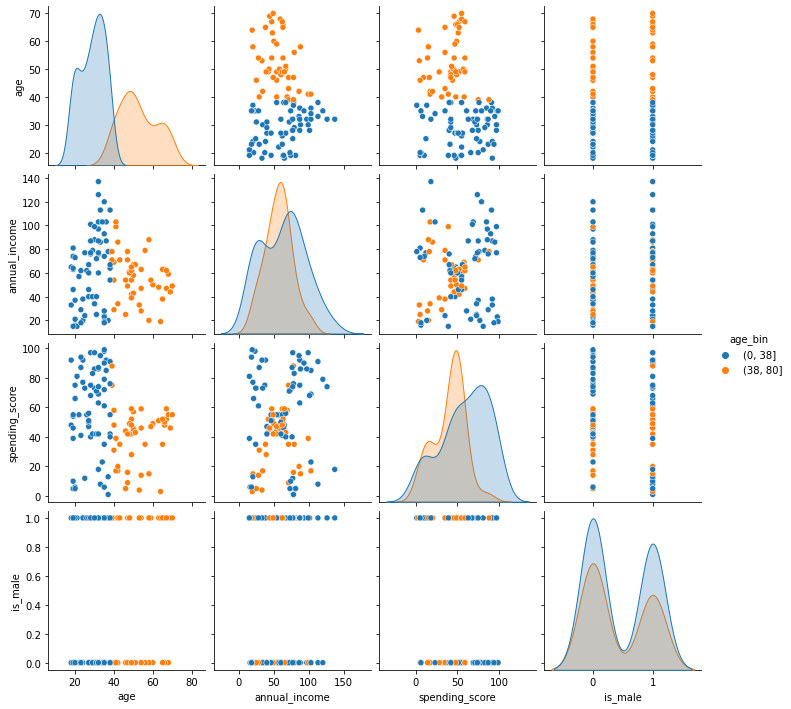

In [21]:

print("Interaction of variables along with younger vs older\n(cutoff=40)")
sns.pairplot(train, hue='age_bin')
plt.show()

Interaction of variables along with income bins


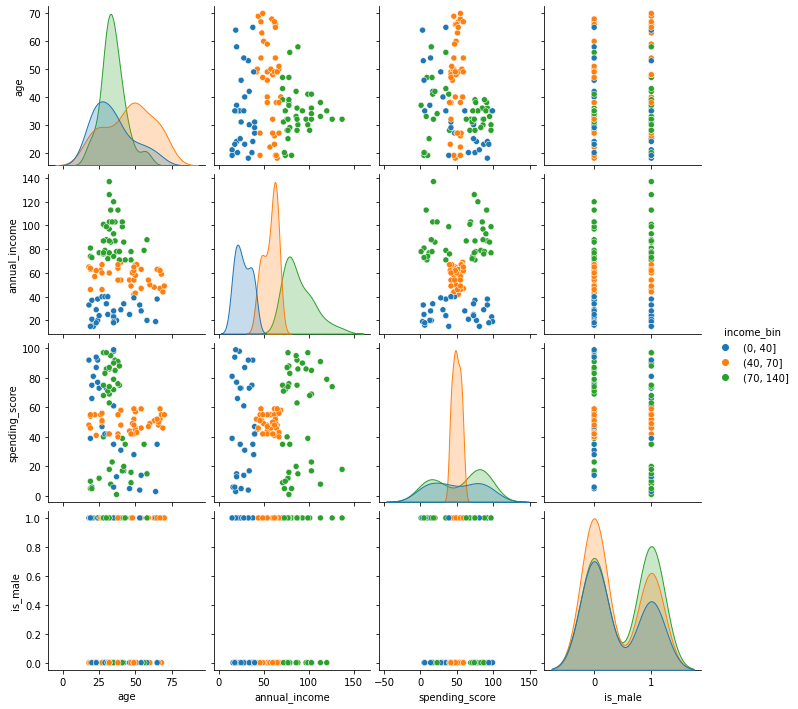

In [22]:

print("Interaction of variables along with income bins")
sns.pairplot(train, hue='income_bin')
plt.show()

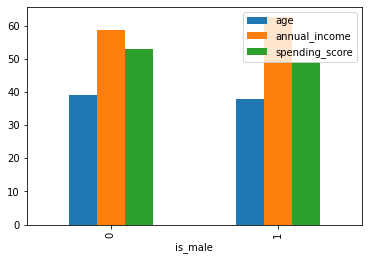

In [23]:
# Creating breakdown by gender
train.groupby('is_male').mean().plot.bar()
plt.show()